# SageMaker Ground Truth and Object Detection


In [1]:
%%time
import sagemaker
from sagemaker import get_execution_role

role = get_execution_role()
print(role)
sess = sagemaker.Session()
BUCKET = sess.default_bucket()
PREFIX = 'input'

arn:aws:iam::893054581338:role/service-role/AmazonSageMaker-ExecutionRole-20210125T173488
CPU times: user 818 ms, sys: 156 ms, total: 975 ms
Wall time: 1.42 s


### Download dataset

In [16]:
!wget http://aws-tc-largeobjects.s3-us-west-2.amazonaws.com/DIG-TF-200-MLBEES-10-EN/dataset.zip 
!unzip -qo dataset.zip

--2021-04-22 09:03:02--  http://aws-tc-largeobjects.s3-us-west-2.amazonaws.com/DIG-TF-200-MLBEES-10-EN/dataset.zip
Resolving aws-tc-largeobjects.s3-us-west-2.amazonaws.com (aws-tc-largeobjects.s3-us-west-2.amazonaws.com)... 52.218.132.250
Connecting to aws-tc-largeobjects.s3-us-west-2.amazonaws.com (aws-tc-largeobjects.s3-us-west-2.amazonaws.com)|52.218.132.250|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70375947 (67M) [application/x-zip-compressed]
Saving to: ‘dataset.zip’

dataset.zip         100%[===================>]  67.12M  12.6MB/s    in 5.7s    

2021-04-22 09:03:09 (11.8 MB/s) - ‘dataset.zip’ saved [70375947/70375947]



### Upload dataset to S3 bucket

In [17]:
!aws s3 sync --exclude="*" --include="[0-9]*.jpg" . s3://$BUCKET/$PREFIX/

upload: ./10006450.jpg to s3://sagemaker-us-east-2-893054581338/input/10006450.jpg 
upload: ./10299519.jpg to s3://sagemaker-us-east-2-893054581338/input/10299519.jpg   
upload: ./10694926.jpg to s3://sagemaker-us-east-2-893054581338/input/10694926.jpg   
upload: ./10250726.jpg to s3://sagemaker-us-east-2-893054581338/input/10250726.jpg   
upload: ./10022723.jpg to s3://sagemaker-us-east-2-893054581338/input/10022723.jpg   
upload: ./10059108.jpg to s3://sagemaker-us-east-2-893054581338/input/10059108.jpg    
upload: ./1063563.jpg to s3://sagemaker-us-east-2-893054581338/input/1063563.jpg      
upload: ./1025450.jpg to s3://sagemaker-us-east-2-893054581338/input/1025450.jpg      
upload: ./10551061.jpg to s3://sagemaker-us-east-2-893054581338/input/10551061.jpg     
upload: ./1060304.jpg to s3://sagemaker-us-east-2-893054581338/input/1060304.jpg       
upload: ./10923199.jpg to s3://sagemaker-us-east-2-893054581338/input/10923199.jpg  
upload: ./10632489.jpg to s3://sagemaker-us-east-2

In [54]:
#replacing bucket name and prefix to right format
outputManifest = open("output.manifest", "rt")
#read file contents to string
manifest = outputManifest.read()
#replace all occurrences of the required string
replaceStr = BUCKET + '/' + PREFIX
manifest = manifest.replace('sagemaker-remars/datasets/na-bees/500', replaceStr)
#close the input file
outputManifest.close()
#open the input file in write mode
outputManifest = open("output.manifest", "wt")
#overrite the input file with the resulting data
outputManifest.write(manifest)
#close the file
outputManifest.close()

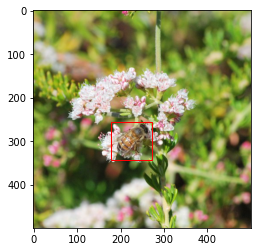

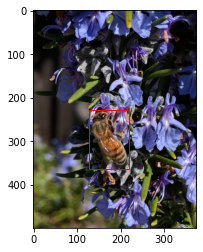

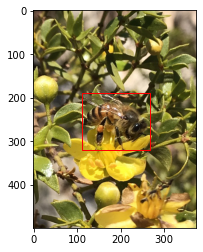

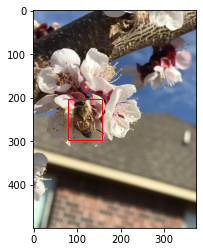

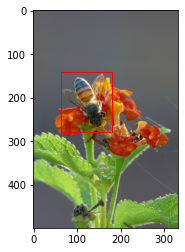

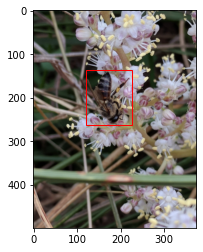

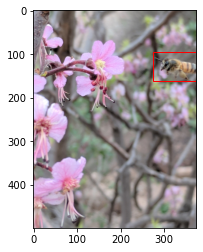

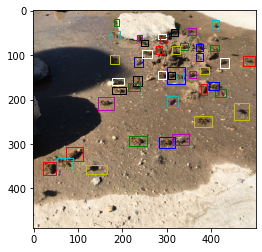

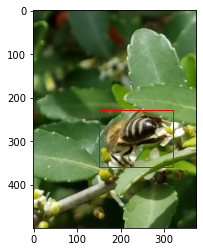

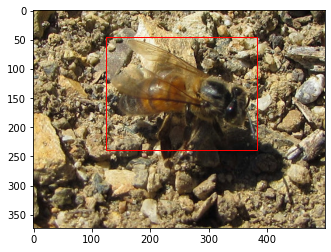

In [55]:
import os
import boto3
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np
from itertools import cycle

labeling_job_name = 'bees-500'


def show_annotated_image(img_path, bboxes):
    im = np.array(Image.open(img_path), dtype=np.uint8)
    
    # Create figure and axes
    fig,ax = plt.subplots(1)

    # Display the image
    ax.imshow(im)

    colors = cycle(['r', 'g', 'b', 'y', 'c', 'm', 'k', 'w'])
    
    for bbox in bboxes:
        # Create a Rectangle patch
        rect = patches.Rectangle((bbox['left'],bbox['top']),bbox['width'],bbox['height'],linewidth=1,edgecolor=next(colors),facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect)

    plt.show()
    

with jsonlines.open('output.manifest', 'r') as reader:
    for desc in islice(reader, 10):
        img_url = desc['source-ref']
        img_file = os.path.basename(img_url)
        file_exists = os.path.isfile(img_file)

        bboxes = desc[labeling_job_name]['annotations']
        show_annotated_image(img_file, bboxes)

 ## Training an Object Detection Model


In [56]:
!pip -q install --upgrade pip
!pip -q install jsonlines

In [57]:
import json
import jsonlines
from itertools import islice
import numpy as np

with jsonlines.open('output.manifest', 'r') as reader:
    lines = list(reader)
    # Shuffle data in place.
    np.random.shuffle(lines)
    
dataset_size = len(lines)
num_training_samples = round(dataset_size*0.8)

train_data = lines[:num_training_samples]
validation_data = lines[num_training_samples:]

augmented_manifest_filename_train = 'train.manifest'

with open(augmented_manifest_filename_train, 'w') as f:
    for line in train_data:
        f.write(json.dumps(line))
        f.write('\n')

augmented_manifest_filename_validation = 'validation.manifest'

with open(augmented_manifest_filename_validation, 'w') as f:
    for line in validation_data:
        f.write(json.dumps(line))
        f.write('\n')
        
print(f'training samples: {num_training_samples}, validation samples: {len(lines)-num_training_samples}')

training samples: 400, validation samples: 100


### Upload manifest filse to S3

In [58]:
pfx_training = PREFIX + '/training' if PREFIX else 'training'
# Defines paths for use in the training job request.
s3_train_data_path = 's3://{}/{}/{}'.format(BUCKET, pfx_training, augmented_manifest_filename_train)
s3_validation_data_path = 's3://{}/{}/{}'.format(BUCKET, pfx_training, augmented_manifest_filename_validation)

!aws s3 cp train.manifest s3://$BUCKET/$pfx_training/
!aws s3 cp validation.manifest s3://$BUCKET/$pfx_training/

upload: ./train.manifest to s3://sagemaker-us-east-2-893054581338/input/training/train.manifest
upload: ./validation.manifest to s3://sagemaker-us-east-2-893054581338/input/training/validation.manifest


### Get model image

In [59]:
from sagemaker.amazon.amazon_estimator import get_image_uri

training_image = get_image_uri(sess.boto_region_name, 'object-detection', repo_version='latest')
print (training_image)

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: latest.


825641698319.dkr.ecr.us-east-2.amazonaws.com/object-detection:1


### Set up model

In [60]:
prefix = 'bees-resnet'

s3_output_loc = 's3://{}/{}/output'.format(sess.default_bucket(), prefix)

In [73]:
model = sagemaker.estimator.Estimator(training_image,
                                     role,
                                     instance_count=1,
                                     instance_type='ml.p2.xlarge',
                                     volume_size = 50,
                                     max_run = 360000,
                                     input_mode= 'Pipe',
                                     output_path=s3_output_loc,
                                     sagemaker_session=sess)

train_data = sagemaker.session.s3_input(s3_train_data_path,
                                        distribution='FullyReplicated',
                                        content_type='application/x-recordio',
                                        s3_data_type='AugmentedManifestFile',
                                        attribute_names=['source-ref', 'bees-500'],
                                        input_mode='Pipe',
                                        record_wrapping='RecordIO') 

validation_data = sagemaker.session.s3_input(s3_validation_data_path,
                                        distribution='FullyReplicated',
                                        content_type='application/x-recordio',
                                        s3_data_type='AugmentedManifestFile',
                                        attribute_names=['source-ref', 'bees-500'],
                                        input_mode='Pipe',
                                        record_wrapping='RecordIO') 

model.set_hyperparameters(base_network='resnet-50',
                                 use_pretrained_model=1,
                                 num_classes=1,
                                 mini_batch_size=1,
                                 epochs=100,
                                 learning_rate=0.0001,
                                 optimizer='sgd',
                                 momentum=0.9,
                                 weight_decay=0.0005,
                                 overlap_threshold=0.5,
                                 nms_threshold=0.45,
                                 image_shape=300,
                                 label_width=350,
                                 early_stopping = True,
                                 early_stopping_min_epochs=50,
                                 early_stopping_patience=5,
                                 early_stopping_tolerance=0.01,  
                                 num_training_samples=400)

The class sagemaker.session.s3_input has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The class sagemaker.session.s3_input has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [74]:
# train_data = sagemaker.inputs.TrainingInput(s3_data = s3_train_data_path,
#                                             s3_data_type='AugmentedManifestFile')
# validation_data = sagemaker.inputs.TrainingInput(s3_data = s3_validation_data_path,
#                                             s3_data_type='AugmentedManifestFile')

data_channels = {'train': train_data, 'validation': validation_data}

### Train model

In [75]:
model.fit(inputs=data_channels, logs=True)


2021-04-22 10:15:44 Starting - Starting the training job...
2021-04-22 10:16:07 Starting - Launching requested ML instancesProfilerReport-1619086544: InProgress
......
2021-04-22 10:17:07 Starting - Preparing the instances for training.........
2021-04-22 10:18:36 Downloading - Downloading input data
2021-04-22 10:18:36 Training - Downloading the training image......
2021-04-22 10:19:44 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
[04/22/2021 10:19:48 INFO 139915256100032] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'label_width': u'350', u'early_stopping_min_epochs': u'10', u'epochs': u'30', u'overlap_threshold': u'0.5', u'lr_scheduler_factor': u'0.1', u'_num_kv_servers': u'auto', u'weight_decay': u'0.0005', u'mini_batch_size': u'32', u'use_pretrained_model': u'0', u'freeze_layer_pattern': u'', u'lr_scheduler_step': u'', u'early_stopping': u'False', u'

### Create Endpoint

In [83]:
object_detector = model.deploy(initial_instance_count = 1,
                                 instance_type = 'ml.m4.xlarge')

---------------!

### Perform inference

In [84]:
import glob
test_images = glob.glob('test/*')

def prediction_to_bbox_data(image_path, prediction):
    class_id, confidence, xmin, ymin, xmax, ymax = prediction
    width, height = Image.open(image_path).size
    bbox_data = {'class_id': class_id,
               'height': (ymax-ymin)*height,
               'width': (xmax-xmin)*width,
               'left': xmin*width,
               'top': ymin*height}
    return bbox_data

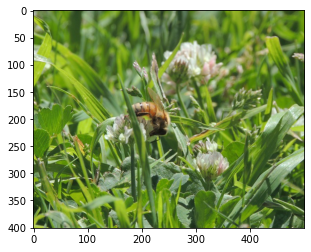

In [89]:
import matplotlib.pyplot as plt

img = plt.imread(test_images[0])
plt.imshow(img)

In [ ]:
import matplotlib.pyplot as plt

runtime_client = boto3.client('sagemaker-runtime')

# Call SageMaker endpoint to obtain predictions
def get_predictions_for_img(runtime_client, endpoint_name, img_path):
    with open(img_path, 'rb') as f:
        payload = f.read()
        payload = bytearray(payload)

    response = runtime_client.invoke_endpoint(EndpointName=endpoint_name, 
                                       ContentType='application/x-image', 
                                       Body=payload)

    result = response['Body'].read()
    result = json.loads(result)
    return result


# wait until the status has changed
client.get_waiter('endpoint_in_service').wait(EndpointName=endpoint_name)
endpoint_response = client.describe_endpoint(EndpointName=endpoint_name)
status = endpoint_response['EndpointStatus']
if status != 'InService':
    raise Exception('Endpoint creation failed.')

for test_image in test_images:
    result = get_predictions_for_img(runtime_client, endpoint_name, test_image)
    confidence_threshold = .5
    best_n = 1
    # display the best n predictions with confidence > confidence_threshold
    predictions = [prediction for prediction in result['prediction'] if prediction[1] > confidence_threshold]
    predictions.sort(reverse=True, key = lambda x: x[1])
    bboxes = [prediction_to_bbox_data(test_image, prediction) for prediction in predictions[:best_n]]
    show_annotated_image(test_image, bboxes)

### Clean up

In [ ]:
client.delete_endpoint(EndpointName=endpoint_name)